In [1]:
#data handling
import pandas as pd 
import re
import numpy as np  

#visualization
import matplotlib.pyplot as plt

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import mutual_info_classif
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

#classification
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score


## Data Reading, Cleaning and Merging

In [2]:
#load the data
topTable = pd.read_csv("topTable.txt", sep="\t", header=0)
targets = pd.read_csv("targets.txt", sep="\t", header=0)

In [3]:
# Replace hyphens with underscores in the 'Sample_ID' column of the sample_info dataframe
targets['Sample_ID'] = targets['Sample_ID'].str.replace('-', '_')
# Use regular expression to make the "Sample_ID" column be the same for both tables
topTable.columns = topTable.columns.str.replace(r'^CPM_([^_]+_[^_]+_[^_]+)_.*$', r'\1', regex=True) 

In [4]:
print('rows,columns')
targets.shape

rows,columns


(40, 9)

In [5]:
print('rows,columns')
topTable.shape

rows,columns


(21246, 86)

In [5]:
#print(targets.columns)
#print(topTable.columns)

In [6]:
# Step 1: Set the 'Sample_ID' as index in `table1`
# This ensures that we can access health status for each sample by its Sample ID.
targets.set_index('Sample_ID', inplace=True)
# Step 2: Identify relevant columns in table2 for CPM values
cpm_columns = [col for col in topTable.columns if re.match(r'^[A-Z0-9]{2}_[0-9]{4}_[A-Z0-9]{2}$', col)]
# Step 3: Filter topTable to keep only the gene IDs and relevant CPM columns
# We assume 'Ensemble_gene_id' is the first column of table2
topTable_filtered = topTable[['ensembl_gene_id'] + cpm_columns]
# Step 4: Set 'Ensemble_gene_id' as index in table2_filtered
topTable_filtered.set_index('ensembl_gene_id', inplace=True)

# Step 5: Transpose table2_filtered so that each sample ID becomes a row, and each gene becomes a column
table2_T = topTable_filtered.transpose()

# Step 6: Join the health status from table1 with the transposed table2
merged_data = table2_T.join(targets['HLAB27_status'])

# Check the resulting merged data structure
print(merged_data.shape)

(40, 21247)


In [7]:
merged_data.iloc[:,0:10].describe()


,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-0.733432,3.826815,5.462939,3.729063,8.974663,2.018766,4.070131,4.961089,6.361143,2.179967
std,0.723182,0.301067,0.178602,0.261728,0.303197,0.758090,0.292899,0.224393,0.193351,0.400910
min,-1.849761,3.223323,4.868904,2.928356,8.246657,-0.081351,3.372040,4.502802,6.021816,1.306086
25%,-1.233521,3.664270,5.389436,3.608136,8.753336,1.478638,3.919874,4.810095,6.239170,1.949381
50%,-0.656452,3.870066,5.441311,3.724967,8.992061,2.121292,4.064582,5.023936,6.326233,2.221575
75%,-0.134252,4.004095,5.565510,3.850191,9.170580,2.510949,4.239225,5.122435,6.413440,2.486007
max,0.488772,4.639166,5.908167,4.329921,9.585564,3.327483,4.874134,5.393953,6.838391,3.059930


In [9]:
merged_data.iloc[:, -10:]

,ENSG00000285923,ENSG00000285933,ENSG00000285938,ENSG00000285943,ENSG00000285966,ENSG00000285967,ENSG00000285976,ENSG00000285984,ENSG00000285994,HLAB27_status
B0_2013_G1,0.9020,0.42100,-1.2900,0.7960,0.9020,4.82,0.27000,-1.29000,4.48,Negative
BB_1987_G1,0.5440,-1.23000,0.2180,0.6830,0.8100,4.52,-0.47400,-1.23000,4.75,Positive
BB_5066_G3,0.6870,0.54800,0.0255,0.2210,1.4000,4.82,0.22100,0.22100,4.69,Negative
BB_5070_G3,0.1620,0.74800,-1.2600,0.1620,0.9710,4.67,-0.84200,-1.26000,4.55,Negative
BB_5072_G3,0.1370,-1.85000,0.9420,0.5950,1.7800,4.66,-0.05520,-0.53900,5.21,Positive
BB_5074_G3,-0.4580,0.97500,-0.9930,1.1300,1.4000,4.98,-0.45800,0.23600,4.55,Negative
BB_5083_G4,1.0400,-0.95800,0.1490,0.9560,-0.4100,4.79,-0.95800,-0.95800,4.35,Positive
BB_5086_G4,-0.1380,1.01000,-0.1380,-0.1380,0.4670,4.31,0.62300,-0.41300,4.59,Negative
BB_5253_G3,-0.1150,-0.58900,0.6500,0.2400,0.2400,4.98,-1.85000,-1.85000,4.91,Negative
BB_5255_G4,0.2290,0.93900,0.0329,0.2290,1.1500,4.85,-1.85000,-0.19400,4.82,Negative


In [10]:
#check for missing values
datanul=merged_data.isnull().sum()
g=[i for i in datanul if i>0]

print('columns with missing values:%d'%len(g))

columns with missing values:0


In [11]:
print("Do we have NA values?")
print(np.any(merged_data.isna()))

print("In case we would have NA values, show these rows")
# Display the na values
display(merged_data[np.any(merged_data.isna(), axis=1)])
print("Empty rows if no NA values")

print("="*79)

print("If we would have NA values, drop the rows containing them")
merged_data.dropna(inplace=True)

Do we have NA values?
False
In case we would have NA values, show these rows


,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000285923,ENSG00000285933,ENSG00000285938,ENSG00000285943,ENSG00000285966,ENSG00000285967,ENSG00000285976,ENSG00000285984,ENSG00000285994,HLAB27_status


Empty rows if no NA values
If we would have NA values, drop the rows containing them


<Axes: >

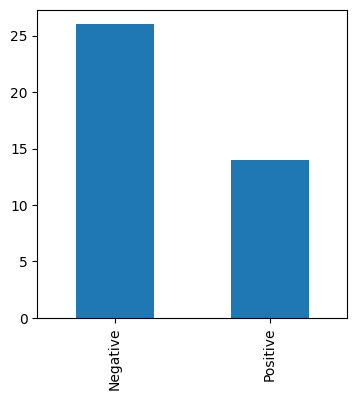

In [10]:
#plot a bar chat to display the class distribution
merged_data['HLAB27_status'].value_counts().plot.bar(figsize=(4,4))

In [13]:
# Look at the correlations between multiple features by displaying a correlation plot (in heatmap form)
#f, ax = plt.subplots(figsize=(20, 8))
#corr= merged_data.corr()
#sns.heatmap(corr,
#            cmap=sns.diverging_palette(220, 10, as_cmap=True),
#            mask=np.zeros_like(corr, dtype=bool),
#            square=True,
#            annot=True,
#            ax=ax)

## Data Preprocessing

In [12]:
X=merged_data.iloc[:,0:-1]
y=merged_data.iloc[:,-1]

In [14]:
merged_data.iloc[:,-1]

B0_2013_G1    Negative
BB_1987_G1    Positive
BB_5066_G3    Negative
BB_5070_G3    Negative
BB_5072_G3    Positive
BB_5074_G3    Negative
BB_5083_G4    Positive
BB_5086_G4    Negative
BB_5253_G3    Negative
BB_5255_G4    Negative
BB_5463_G3    Positive
BB_5466_G3    Positive
BB_5761_G4    Negative
BB_5767_G3    Negative
BB_6267_G4    Negative
BB_6404_G4    Negative
BB_6797_G3    Positive
BB_6830_G4    Negative
BB_7018_G4    Negative
BB_9104_G4    Negative
BP_0061_G2    Positive
BP_0067_G1    Positive
BP_0069_G2    Negative
BP_0079_G2    Negative
BP_0080_G2    Negative
BP_0081_G2    Positive
BP_0085_G2    Positive
BP_0087_G2    Positive
BP_0088_G2    Negative
BP_0093_G1    Negative
BP_0113_G1    Positive
BP_0114_G2    Negative
BP_0145_G1    Negative
BP_0443_G1    Positive
BP_0492_G1    Negative
BP_0595_G2    Negative
BP_1020_G1    Positive
BP_1264_G1    Negative
BP_5069_G3    Negative
BP_6789_G4    Negative
Name: HLAB27_status, dtype: object

In [12]:
X.shape

(40, 21246)

In [15]:
y.shape

(40,)

In [18]:
### Making y variable from categorical into numeric (if  needed)
#### Hardcode method
#replace Negative and Positive with 0 and 1
#merged_data.replace({'HLAB27_status': {'Positive':1,'Negative':0}}, inplace=True)

#### Automatic method
#let's encode target labels (y) with values between 0 and n_classes-1.
#encoding will be done using the LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(y)
y_encoded=label_encoder.transform(y)
labels=label_encoder.classes_
classes=np.unique(y_encoded)

In [15]:
labels

array(['Negative', 'Positive'], dtype=object)

In [16]:
classes

array([0, 1])

In [19]:
#split data into training and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y_encoded,test_size=0.2,random_state=42)

In [20]:
# scale data between 0 and 1

min_max_scaler=MinMaxScaler()
X_train_norm=min_max_scaler.fit_transform(X_train)
X_test_norm=min_max_scaler.fit_transform(X_test)

In [21]:
MI=mutual_info_classif(X_train_norm,y_train)
#select top n features. lets say 300.
#you can modify the value and see how the performance of the model changes

n_features=10000
selected_scores_indices=np.argsort(MI)[::-1][0:n_features]
X_train_selected=X_train_norm[:,selected_scores_indices]
X_test_selected=X_test_norm[:,selected_scores_indices]
X_train_selected.shape

(32, 10000)

In [22]:
X_test_selected.shape

(8, 10000)

In [24]:
#select top n features. lets say 300.
#you can modify the value and see how the performance of the model changes

n_features=300
selected_scores_indices=np.argsort(MI)[::-1][0:n_features]

In [25]:
X_train_selected=X_train.iloc[:, selected_scores_indices]
X_test_selected=X_test.iloc[:, selected_scores_indices]

In [26]:
X_train_selected.shape

(32, 300)

In [27]:
X_test_selected.shape

(8, 300)

In [31]:
# transform the dataset
oversample = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train_selected, y_train)
# summarize the new class distribution
counter = Counter(y_train_resampled)
print(counter)

Counter({0: 22, 1: 22})


In [23]:
# scale data between 0 and 1
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train_selected)
X_test_norm = min_max_scaler.transform(X_test_selected)

In [24]:
# Final shapes
print("X_train_norm shape:", X_train_norm.shape)
print("X_test_norm shape:", X_test_norm.shape)

X_train_norm shape: (32, 10000)
X_test_norm shape: (8, 10000)


In [42]:
#BOTH CELLS UNDERNEATH ARE FOR A LOGISTIC REGRESSION MODEL BUT THE RESULTS WERE VERY WEAK AND THUS NOT USABLE
## Initialize a logistic regression model, fit the data. Start with a C-value of 1
#model= LogisticRegression(C=1, class_weight='balanced')
#model.fit(X_train_norm,y_train_resampled)
#y_pred = model.predict(X_test_norm)
#print(y_pred)

[0 0 0 0 0 1 0 0]


In [43]:
## Check if you have over- or underfitting of your model by comparing the score of the training and test set
#print("Accuracy on the training set:",model.score(X_train_norm,y_train_resampled))
#print("Accuracy on the test set:",model.score(X_test_norm,y_test))
#print("="*80)
#
## Predict values for the test set
#y_pred=model.predict(X_test_norm)
#
## Look at the confusion matrix, what do the different values mean in this case?
## Hint: if you don't know the syntax/meaning for a specific funtion, you can always look this up
## in jupyter notebook by executing "?function_name"
#print("Confusion matrix:\n",confusion_matrix(y_true=y_test,y_pred=y_pred))
#print("="*80)
#
## Show the accuracy, recall, precision and f1-score for the test set
## Note, sometimes you need to supply a positive label (if not working with 0 and 1)
## supply this with "pos_label='label'", in this case, the malign samples are the positives
#print("Long way:")
#print(" Accuracy:", accuracy_score(y_test, y_pred))
#print("   Recall:", recall_score(y_test, y_pred, average='macro'))  # Change average to 'macro'
#print("Precision:", precision_score(y_test, y_pred, average='macro'))  # Change average to 'macro'
#print(" F1-score:", f1_score(y_test, y_pred, average='macro'))  # Change average to 'macro'
#print("=" * 80)
#print("Short way:")
#print(classification_report(y_test, y_pred))
#print("=" * 80)

Accuracy on the training set: 1.0
Accuracy on the test set: 0.375
Confusion matrix:
 [[3 1]
 [4 0]]
Long way:
 Accuracy: 0.375
   Recall: 0.375
Precision: 0.21428571428571427
 F1-score: 0.2727272727272727
Short way:
              precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.00      0.00      0.00         4

    accuracy                           0.38         8
   macro avg       0.21      0.38      0.27         8
weighted avg       0.21      0.38      0.27         8



In [25]:
#Random Forest Classifier
#because we are dealing with multiclass data, the one versus rest strategy is used.
#learn to predict each class against the other.

RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train_norm,y_train)
y_pred =RF.predict(X_test_norm)
pred_prob = RF.predict_proba(X_test_norm)

In [26]:
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1score
f1score=np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score)


report=classification_report(y_test,y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.5000
precision:0.2500
recall:0.5000
f1score:0.3333


classification report


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         4
    Positive       0.00      0.00      0.00         4

    accuracy                           0.50         8
   macro avg       0.25      0.50      0.33         8
weighted avg       0.25      0.50      0.33         8



/home/guest/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guest/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guest/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guest/.local/lib/py